# Grocery and Gourmet Recommendation Challenge

The purpose of this challenge is to build a recommendation model that will allow to increase the average bill in the online shop by recommending shoppers specific items.

We have the following dataset test.csv which we can use for making predictions. Each set of pairs **userid - itemid** has its own **id**, for which we should do a prediction.

**The features are the following:**
* overall - rating set by the user 
* verified - was the review verified or not 
* reviewTime - the time when review was written
* reviewerName - user name
* reviewText - full review text
* summary - summary of the review text
* vote - a number of votes for the review
* style - metadata
* image - image of the product
* userid - id of the user
* itemid - id of the product
* id - id for prediction

In [1]:
## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Any results you write to the current directory are saved as output.
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recommendationsv4/sample_submission.csv
/kaggle/input/recommendationsv4/train.csv
/kaggle/input/recommendationsv4/test.csv
/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json


In [2]:
#Importing additional libraries

#Hyperparameters optimization
import itertools

import scipy.sparse as sparse

from datetime import datetime

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

## Functions

In [3]:
#Hyperparameters tunung functions
def sample_hyperparameters():
    """
    Yield possible hyperparameter choices.
    """

    while True:
        yield {
            "no_components": np.random.randint(16, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }

In [4]:
#Hyperparameters tunung functions
# Random Search
def random_search(train, test, num_samples=10, num_threads=1):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.

    Parameters
    ----------

    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.


    Returns
    -------

    generator of (auc_score, hyperparameter dict, fitted model)

    """

    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams)
        model.fit(train, epochs=num_epochs, num_threads=num_threads)

        score = auc_score(model, test, train_interactions=train, num_threads=num_threads).mean()

        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)

In [5]:
#Removing comma from vote values
def remove_comma(vote):    
    if type(vote) == str:
        if "," in vote:
            return (int(vote.replace(",", "")))
    return vote   

In [6]:
#Function that drwas ROC-curve
def roc_auc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot([0, 1], label='Случайный классификатор', linestyle='--')
    plt.plot(fpr, tpr, label = 'LightFM')
    plt.title('ROC AUC = %0.3f' % roc_auc_score(y_true, y_pred_prob))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

In [7]:
# Function to convert revie date into a number
def cat_date(x):
    if x <= ts25: x = 1
    elif ts25 < x < ts75: x = 2
    elif ts75 <= x: x = 3
    return x

#### Variables

In [8]:
RANDOM_STATE = 34

In [9]:
#Reading files contents
train = pd.read_csv('/kaggle/input/recommendationsv4/train.csv')
test = pd.read_csv('/kaggle/input/recommendationsv4/test.csv')
submission = pd.read_csv('/kaggle/input/recommendationsv4/sample_submission.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Inspection

In [10]:
# Initial Data Inspection
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', train.shape)
display(train.head(5))
print('Размерность тестового датасета: ', test.shape)
display(test.head(5))
#print('Размерность мета датасета: ', meta.shape)
#display(meta.head(5))

Размерность тренировочного датасета:  (857895, 14)


,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,5.0,True,"09 5, 2013",B00MRAQUM8,Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,5.0,True,"09 14, 2016",B000R7RN0G,Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0


Размерность тестового датасета:  (285965, 11)


,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,Id
0,True,"10 1, 2016",B001E5E3X0,Rudys Mom,1475280000,NaN,NaN,NaN,68877,7506,0
1,True,"06 29, 2014",B005BYXX5E,pharg,1404000000,2,NaN,NaN,50442,15530,1
2,True,"05 19, 2015",B0052OK6OO,dhalex,1431993600,NaN,NaN,NaN,64349,15049,2
3,True,"10 5, 2014",B003SO8HGE,Vanessa,1412467200,NaN,{'Flavor:': ' Sweet Rose'},NaN,26206,11957,3
4,True,"11 11, 2013",B003XUJ564,R Mohrman,1384128000,3,"{'Size:': ' 15 Ounce (Pack of 12)', 'Flavor:':...",NaN,59366,12173,4


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         857895 non-null  float64
 1   verified        857895 non-null  bool   
 2   reviewTime      857895 non-null  object 
 3   asin            857895 non-null  object 
 4   reviewerName    857719 non-null  object 
 5   reviewText      857616 non-null  object 
 6   summary         857725 non-null  object 
 7   unixReviewTime  857895 non-null  int64  
 8   vote            118740 non-null  object 
 9   style           444406 non-null  object 
 10  image           7142 non-null    object 
 11  userid          857895 non-null  int64  
 12  itemid          857895 non-null  int64  
 13  rating          857895 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 85.9+ MB


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   verified        285965 non-null  bool  
 1   reviewTime      285965 non-null  object
 2   asin            285965 non-null  object
 3   reviewerName    285918 non-null  object
 4   unixReviewTime  285965 non-null  int64 
 5   vote            39462 non-null   object
 6   style           147680 non-null  object
 7   image           2368 non-null    object
 8   userid          285965 non-null  int64 
 9   itemid          285965 non-null  int64 
 10  Id              285965 non-null  int64 
dtypes: bool(1), int64(4), object(6)
memory usage: 22.1+ MB


## Exploratory Data Analysis

First of all let's check if our training dataset has duplicated pairs userid-itemid, and if it has, let's get rid of them

In [13]:
train[train.duplicated(subset=['userid', 'itemid'])].sort_values(['userid', 'itemid'], ascending = (False, True))

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
142161,5.0,True,"08 4, 2016",B00ZW60PCA,"EuiTaek, Y.",Good,Five Stars,1470268800,NaN,{'Style:': ' Cranberry'},NaN,127495,41097,1.0
797847,5.0,True,"08 4, 2016",B00ZW60PCA,"EuiTaek, Y.",Taste so good,Five Stars,1470268800,NaN,{'Style:': ' Acai Berry'},NaN,127495,41097,1.0
190592,2.0,True,"01 5, 2017",B017LXVT12,Earl J. Byard,"not for me bad taste , soap",not again,1483574400,NaN,{'Flavor:': ' Elk Roasted Garlic Cheddar'},NaN,127437,35950,0.0
546500,2.0,True,"01 5, 2017",B017LXVT12,Earl J. Byard,not for me bad taste like soap,no,1483574400,NaN,{'Flavor:': ' Bison Chipotle Cheddar'},NaN,127437,35950,0.0
560085,2.0,True,"01 5, 2017",B017LXVT12,Earl J. Byard,not for me bad taste like soap,no,1483574400,NaN,{'Flavor:': ' Pheasant Smoked Gouda'},NaN,127437,35950,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717734,5.0,True,"06 23, 2016",B00136MKEO,ALFRED W,GOOD,GOOD,1466640000,NaN,{'Flavor:': ' Special Blend'},NaN,20,5895,1.0
720963,5.0,True,"06 23, 2016",B00136MKEO,ALFRED W,GOOD,GOOD,1466640000,NaN,{'Flavor:': ' Cardamom'},NaN,20,5895,1.0
593422,5.0,True,"03 4, 2017",B000YF4PZW,Kindle Customer,"Wow, I've never had Mince pie before now. I'm ...",Sweet and fresh,1488585600,NaN,NaN,NaN,14,5298,1.0
458488,5.0,True,"11 3, 2015",B0016BFR4G,Metajohn,This is a high quality green tea. Price also ...,Drink every day!,1446508800,NaN,{'Size:': ' Pack of 1'},NaN,7,6473,1.0


#### As we can see there is a lot of duplicated records in the reviews dataset. Let's get rid of them

In [14]:
train.drop_duplicates(inplace = True)

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828935 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         828935 non-null  float64
 1   verified        828935 non-null  bool   
 2   reviewTime      828935 non-null  object 
 3   asin            828935 non-null  object 
 4   reviewerName    828771 non-null  object 
 5   reviewText      828661 non-null  object 
 6   summary         828769 non-null  object 
 7   unixReviewTime  828935 non-null  int64  
 8   vote            115991 non-null  object 
 9   style           429265 non-null  object 
 10  image           7026 non-null    object 
 11  userid          828935 non-null  int64  
 12  itemid          828935 non-null  int64  
 13  rating          828935 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 89.3+ MB


#### Let's look at the data and see which feature we will use in our model and which - not. Also, let's see if we need to manipulate on some features and if it's possible to engineer new features.

#### Let's first create a list to store those features that we will remove

In [16]:
train_to_remove = []

#### From the first glance it is obvious that dataset contains features that can not be useful for building the model. The first one is **reviewerName**. There should not be any dependency between reviewer name and his or her review. Also, it seems that we have two features that mean the time of the review, they just have a different format. Though it is a contraversial question, I would keep the Unix-time format in the dataset and remove the daye format

In [17]:
train_to_remove.append('reviewerName')
train_to_remove.append('reviewTime')

#### Also I suggest to remove **overall** feature from the dataset as long as we have a derivative feature from **overall**, namely **rating**

In [18]:
train_to_remove.append('overall')

In [19]:
train_to_remove

['reviewerName', 'reviewTime', 'overall']

#### Let's look at other features

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828935 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         828935 non-null  float64
 1   verified        828935 non-null  bool   
 2   reviewTime      828935 non-null  object 
 3   asin            828935 non-null  object 
 4   reviewerName    828771 non-null  object 
 5   reviewText      828661 non-null  object 
 6   summary         828769 non-null  object 
 7   unixReviewTime  828935 non-null  int64  
 8   vote            115991 non-null  object 
 9   style           429265 non-null  object 
 10  image           7026 non-null    object 
 11  userid          828935 non-null  int64  
 12  itemid          828935 non-null  int64  
 13  rating          828935 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 89.3+ MB


In [21]:
train.verified.value_counts(normalize=True)

True     0.868378
False    0.131622
Name: verified, dtype: float64

#### We see that 13% of the reviews are not verified and all the rest were verified. When building a model we can use only verified reviews or keep all the reviews. We Will try both approaches.

In [22]:
train.asin.value_counts()

B00BUKL666    5430
B00D3M2QP4    4733
B008QMX2SG    4611
B00R7PWK7W    2449
B000F4DKAI    2166
              ... 
B001682U6M       1
B00F9WMZO8       1
B00TH3N6KM       1
B001EO5KJM       1
B007PEHCFK       1
Name: asin, Length: 41302, dtype: int64

#### Asin Feature looks like an item identifier, I don't see any practical use of it for now. However, it may be useful for merging our train dataset with the dataset with extra data. Let's think of it later. But for now let's get rid of this feature

In [23]:
train_to_remove.append('asin')

In [24]:
train.reviewText.value_counts()

good                                                                                                                        3019
great                                                                                                                       2525
Great                                                                                                                       2002
Good                                                                                                                        1977
ok                                                                                                                          1278
                                                                                                                            ... 
Bob's Red Mill 10Grain Bread Mix , I realy like this product. Easy to make and never fails ,also like the tast.                1
Best habanero hot sauce I've ever had.  I know they are more known for their tobasco type peppers

In [25]:
train.reviewText.isna().sum()

274

Feature **reviewText** is basically the full review of the product. As we can see quite often the review contains just one word. I suggest to drop this feature. Though the deep analysis of the large reviews may be useful, I think it is not worth effirts spent on it. Probably we can get the same information from **summary** feature, because in reality what really matters here is whether the review was positive or negative.

In [26]:
train_to_remove.append('reviewText')

In [27]:
train.summary.value_counts()

Five Stars                                                  167474
Four Stars                                                   26017
Three Stars                                                  11686
One Star                                                      5213
Two Stars                                                     4831
                                                             ...  
The Longer It Stays . . .                                        1
LOVE these !!!!                                                  1
Very useful for the period.                                      1
Great on finger sandwiches!                                      1
Arrived promptly. When I got them I immediately made ...         1
Name: summary, Length: 411451, dtype: int64

In [28]:
train.summary.isna().sum()

166

I guess we can use **summary** feature as an parameters for the model, however, we need to work on it in order to adjust in different representation. Also, as there are 170 missing values we will nedd to fill these missing values with some value

In [29]:
train.vote.value_counts()

2.0      30083
3.0      15036
2        13464
4.0       8670
3         6806
         ...  
507.0        1
576.0        1
122.0        1
577.0        1
152          1
Name: vote, Length: 477, dtype: int64

In [30]:
train[train.vote == 0]

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating


The feature **vote** seems to be quite an important feature because it looks logical that the more votes the review has, the more helpful it is. However, the **vote** feature seems to have a lot of missing values. I suggest to replace missing vote values with 0. As we don't have 0 as a value in the vote column, I believe that the cell is empty when there is no vote i.e. 0 votes

In [31]:
# Adjusting "vote" feature on train
train['vote'] = train['vote'].apply(remove_comma)
train['vote'] = train['vote'].apply(lambda x: int(x) if x == x else "")
train['vote'] = train['vote'].apply(lambda x: x if type(x) == int else 0)

In [32]:
train['style'].value_counts()

{'Size:': ' Pack of 1'}                                                         4582
{'Package Quantity:': ' 1'}                                                     4470
{'Package Type:': ' Standard Packaging'}                                        3880
{'Size:': ' 1 Pack'}                                                            3707
{'Size:': ' 24 Count'}                                                          3615
                                                                                ... 
{'Size:': ' 5.8 ounce  (Pack of 12)', 'Flavor:': ' Cardomom Chai'}                 1
{'Size:': ' 12.75 Ounce (Pack of 8)', 'Flavor:': ' Cinnamon Toast Crunch'}         1
{'Size:': ' 3.5 oz (6 count)', 'Flavor:': ' Almond Blueberry Lemon'}               1
{'Size:': ' 1.5-Ounce Bags (Pack of 10)', 'Flavor:': ' Jalapeno Carne Seca'}       1
{'Size:': ' 9-Ounce (Pack of 6)', 'Flavor:': ' Toasted Asiago'}                    1
Name: style, Length: 25892, dtype: int64

It looks like the **style** feature is just a certain characteristics of the product. We see that there a lot of different charactersitics, but in most cases the value is missing. So, I suggest to get rid of this feature and not use it for analysis

In [33]:
train_to_remove.append('style')

In [34]:
train['image'].value_counts()

['https://images-na.ssl-images-amazon.com/images/I/71+Z1TA3eyL._SY88.jpg']                                                                                                                                                                                                                                  6
['https://images-na.ssl-images-amazon.com/images/I/712zJIOTV5L._SY88.jpg']                                                                                                                                                                                                                                  6
['https://images-na.ssl-images-amazon.com/images/I/81h8Zc+1rzL._SY88.jpg']                                                                                                                                                                                                                                  5
['https://images-na.ssl-images-amazon.com/images/I/81kah7EsJtL._SY88.jpg', 'https://images-na.

Well, the feature **images**, basically contains the url to the image. We can probably convert it into binary feature i.e. image present or not and use it in our analysis, because items with images probably can get more reviews. Let's check that assumption

In [35]:
train_with_images = train[train['image'].notnull()]

In [36]:
train_with_images.shape

(7026, 14)

In [37]:
train_without_images = train[train['image'].isna()]

In [38]:
train_without_images.shape

(821909, 14)

In [39]:
train_with_images.rating.value_counts(normalize=True)

1.0    0.755622
0.0    0.244378
Name: rating, dtype: float64

In [40]:
train_without_images.rating.value_counts(normalize=True)

1.0    0.849067
0.0    0.150933
Name: rating, dtype: float64

The rest of the features which are **userid**, **itemid** and **rating** are the necessary features for building the model. So we should definitely keep them. The only thing which is worth noticing is that any of these features has missing values, so we're fine here.

#### Let's now drop those feature that we found unnecessary and see what we got

In [41]:
train.drop(columns = train_to_remove, inplace = True)

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828935 entries, 0 to 857894
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   verified        828935 non-null  bool   
 1   summary         828769 non-null  object 
 2   unixReviewTime  828935 non-null  int64  
 3   vote            828935 non-null  int64  
 4   image           7026 non-null    object 
 5   userid          828935 non-null  int64  
 6   itemid          828935 non-null  int64  
 7   rating          828935 non-null  float64
dtypes: bool(1), float64(1), int64(4), object(2)
memory usage: 51.4+ MB


## Feature Engineering

#### Let's now work on the remaining features to convert them into format that we can be used by machine learning algorythms

#### Let's convert **verified** feature into binary format 

In [43]:
train.verified = train.verified.apply(lambda x : 1 if x == True else 0)

In [44]:
train.verified.value_counts()

1    719829
0    109106
Name: verified, dtype: int64

#### Let's now try to look what we can do with **unixReviewTime** feature. Let's see what is the period during which the review

In [45]:
tsmin = datetime.utcfromtimestamp(train.unixReviewTime.min()).strftime('%Y-%m-%d %H:%M:%S')
tsmax = datetime.utcfromtimestamp(train.unixReviewTime.max()).strftime('%Y-%m-%d %H:%M:%S')

In [46]:
print(tsmin)
print(tsmax)

2000-08-09 00:00:00
2018-10-02 00:00:00


#### We can see that the review were collected for quite a long period - 18 years. I guess that the idea here can be to split the overall period into three groups - "old", "new" and "middle", turn it into numeric format and then add it as a separate feature. Let's do this

In [47]:
tsmin = train.unixReviewTime.min()
ts25 = int(train.unixReviewTime.quantile(0.25))
ts50 = int(train.unixReviewTime.quantile(0.50))
ts75 = int(train.unixReviewTime.quantile(0.75))
tsmax = train.unixReviewTime.max()

In [48]:
train['unixReviewTime'] = train['unixReviewTime'].apply(lambda x: cat_date(x))

In [49]:
train.head()

,verified,summary,unixReviewTime,vote,image,userid,itemid,rating
0,1,Must Add to your Spice kitchen!,2,0,NaN,102179,37138,1.0
1,1,Milk Chocolate Swiis MIss Hot Cocoa Mix,2,0,NaN,3625,17322,1.0
2,1,"Love these sugar free syrups, but didn't love ...",2,28,NaN,39495,5600,1.0
3,1,Nice !,1,0,NaN,72854,30249,1.0
4,1,These are my favorite jalapeno chips so far,2,0,NaN,74859,4349,1.0


#### Let's now work on the **image** feature. The idea here is to change image into binary feature, where 1 means that image is present and 0 means that the image is absent

In [50]:
train.image.fillna(0, inplace = True)
train.image = train.image.apply(lambda x : 1 if x !=0 else x)

In [51]:
train.image.value_counts()

0    821909
1      7026
Name: image, dtype: int64

In [52]:
train.head()

,verified,summary,unixReviewTime,vote,image,userid,itemid,rating
0,1,Must Add to your Spice kitchen!,2,0,0,102179,37138,1.0
1,1,Milk Chocolate Swiis MIss Hot Cocoa Mix,2,0,0,3625,17322,1.0
2,1,"Love these sugar free syrups, but didn't love ...",2,28,0,39495,5600,1.0
3,1,Nice !,1,0,0,72854,30249,1.0
4,1,These are my favorite jalapeno chips so far,2,0,0,74859,4349,1.0


#### Let's now try to work on **summary** feature. It will be a little bit tricky. Let's try to extract to figure out the tone of the summary review based on the words included

In [53]:
# A dictionary for collecting the words and their counts
strdict = {}

In [54]:
# Function that fills dictionary with words and their counts from the string
def update_strdict(str, strdict):    
    str.replace(",", " ")
    strs = str.split(" ")
    for onestr in strs:
        onestr = onestr.rstrip()
        if onestr in strdict:
            strdict[onestr] = strdict[onestr] + 1
        else:
            strdict[onestr] = 1          

In [55]:
# Function that forms a dictionary from Series
def form_strdict(summary, strdict):
    for item in summary:
        if type(item) == str:
            update_strdict(item, strdict)
    return strdict

In [56]:
strdict = form_strdict(train.summary, strdict)

In [57]:
# Let`s now go through the dictionary and extract the most popular words and form the list of positive and negative words:
words = []
for key in strdict:
    if strdict[key] > 500:
        words.append(key)

In [58]:
len(words)

737

In [59]:
words

['Must',
 'to',
 'your',
 'Spice',
 'Milk',
 'Chocolate',
 'Hot',
 'Mix',
 'Love',
 'these',
 'sugar',
 'free',
 'but',
 "didn't",
 'love',
 'the',
 'price!',
 'Nice',
 '!',
 'These',
 'are',
 'my',
 'favorite',
 'chips',
 'so',
 'far',
 'best',
 'tea',
 'taste',
 'Five',
 'Stars',
 'low',
 'carb',
 'Tasty,',
 'a',
 'better',
 'it!',
 'in',
 'pretty',
 'Two',
 'I',
 'drink',
 'lot',
 'of',
 'instant',
 'coffee',
 'and',
 'this',
 'stuff',
 'good.',
 'No',
 'different',
 'than',
 'good',
 'flavor,',
 'more',
 'store',
 'blend',
 'Four',
 'THIS',
 'IS',
 'Great',
 'Tea',
 'Blend',
 'with',
 'This',
 'The',
 'We',
 'really',
 'get',
 'they',
 'VERY',
 'Do',
 'not',
 '1',
 'out',
 '5',
 'did',
 '...',
 'one',
 'use',
 'oatmeal',
 'Amazing',
 'is',
 'taste!',
 'delicious',
 'Excellent',
 'flavor',
 'quality',
 'snack',
 'best!',
 'Fantastic',
 'taste.',
 'My',
 'kids',
 '&',
 'it,',
 'it',
 'Perfect',
 'for',
 'Good',
 'dark',
 'roast',
 'Quick',
 'chocolate',
 'make',
 'me',
 'wish',
 'wer

In [60]:
# These list of positive word and negative words were formed manually under the human supervision
positives = [
    "best",
    "good",
    "great",
    "love",
    "delicious",
    "nice",
    "favorite",
    "tasty",
    "perfect",
    "excellent",
    "wonderful",
    "enjoy",
    "yummy",
    "happy",
    "loves",
    "loved",
    "amazing",
    "awesome",
    "yum",
    "enjoyed",
    "fantastic",
    "perfectly",
    "wow",
    "lovely",
    "beautiful",
    "terrific",
    "enjoyable"
]

negatives = [
    "awful",
    "bad",
    "disappointed",
    "unfortunate",
    "waste",
    "weird",
    "difficult",
    "terrible",
    "horrible",
    "complaint",
    "gross",
    "worst",
    "strange",
    "fake",
    "disappointing",
    "complaints",
    "poor",
    "sucks"
]

In [61]:
# Let's create an extra feature summary_tone that will take 1 if the tone of the review is positive, -1 if it is negative and 0 if it is neutral 
# (the summary text doesn`t contain any of the words from the list)
def summary_tone(text):
    for item in positives:
        if item in text:
            return 1
    for item in negatives:
        if item in text:
            return -1
    return 0

In [62]:
# Filling NA values with string of "0" for better processing
train['summary'].fillna("0", inplace = True)

In [63]:
train['summary_tone'] = train['summary'].apply(summary_tone)

In [64]:
train.head()

,verified,summary,unixReviewTime,vote,image,userid,itemid,rating,summary_tone
0,1,Must Add to your Spice kitchen!,2,0,0,102179,37138,1.0,0
1,1,Milk Chocolate Swiis MIss Hot Cocoa Mix,2,0,0,3625,17322,1.0,0
2,1,"Love these sugar free syrups, but didn't love ...",2,28,0,39495,5600,1.0,1
3,1,Nice !,1,0,0,72854,30249,1.0,0
4,1,These are my favorite jalapeno chips so far,2,0,0,74859,4349,1.0,1


In [65]:
train.summary_tone.value_counts()

 0    667976
 1    152916
-1      8043
Name: summary_tone, dtype: int64

In [66]:
train.drop(columns = ['summary'], inplace = True)

In [67]:
train.head()

,verified,unixReviewTime,vote,image,userid,itemid,rating,summary_tone
0,1,2,0,0,102179,37138,1.0,0
1,1,2,0,0,3625,17322,1.0,0
2,1,2,28,0,39495,5600,1.0,1
3,1,1,0,0,72854,30249,1.0,0
4,1,2,0,0,74859,4349,1.0,1


In [68]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828935 entries, 0 to 857894
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   verified        828935 non-null  int64  
 1   unixReviewTime  828935 non-null  int64  
 2   vote            828935 non-null  int64  
 3   image           828935 non-null  int64  
 4   userid          828935 non-null  int64  
 5   itemid          828935 non-null  int64  
 6   rating          828935 non-null  float64
 7   summary_tone    828935 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 56.9 MB


#### We can see that, besides the **userid** and **itemid** features we have just one aditional feature that is nominal. It is **vote**. Also we have two binary features - **image** and **verified**, and two ordinal features **unixReviewTime** and **summary_tone**. Let,s split tem into separate lists of features

In [69]:
bin_cols = ['verified', 'image']
ord_cols = ['unixReviewTime', 'summary_tone']

#### Let's try to figure out the importance of each feature

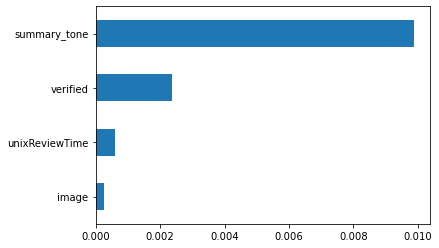

In [70]:
#Figuring out importance of binary features
imp_cat = pd.Series(mutual_info_classif(train[bin_cols + ord_cols], train['rating'],
                                     discrete_features =True), index = bin_cols + ord_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

#### As we can see the features **summary_tone** and **verified** are more important than **unixReviewTime** and **image**, so we could probably use them first of all as item_features

#### But first let's build a default model. 

## Building a Model

### Let's start with building a default model

In [71]:
# Let`s split dataset into training and validation part
train_data, test_data = train_test_split(train,random_state=32, shuffle=True)

In [72]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

In [73]:
#Default model without user_features. All parameters - by default

model0 = LightFM()
model0 = model0.fit(ratings_coo)

In [74]:
#Preds for ROC AUC
preds0 = model0.predict(test_data.userid.values,
                      test_data.itemid.values)

In [75]:
sklearn.metrics.roc_auc_score(test_data.rating,preds0)

0.610340511241432

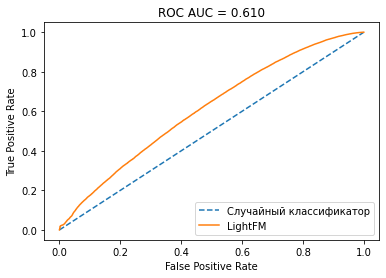

In [76]:
roc_auc_curve(test_data.rating,preds0)

#### As you can see the result of naive model is not quite good. Let's try other options

### Hyperparameters tuning

#### Let's try to find the best hyperparameters for the model with Random Search method

In [77]:
train_hyper = train.drop_duplicates(subset = ['userid', 'itemid'])

In [78]:
'''#Hyperparameters tuning
train_coo = sparse.coo_matrix((train_hyper['rating'].astype(int),
                                 (train_hyper['userid'],
                                  train_hyper['itemid'])))

train_data, test_data = random_train_test_split(train_coo)


(score, hyperparams, model) = max(random_search(train_data, test_data, num_threads=2), key=lambda x: x[0])
print("Best score {} at {}".format(score, hyperparams))'''

'#Hyperparameters tuning\ntrain_coo = sparse.coo_matrix((train_hyper[\'rating\'].astype(int),\n                                 (train_hyper[\'userid\'],\n                                  train_hyper[\'itemid\'])))\n\ntrain_data, test_data = random_train_test_split(train_coo)\n\n\n(score, hyperparams, model) = max(random_search(train_data, test_data, num_threads=2), key=lambda x: x[0])\nprint("Best score {} at {}".format(score, hyperparams))'

The Random Search returned the following list of the best hyperparameters: </br> **Best score** 0.7920857071876526 at {'no_components': 17, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.004423426860837156, 'item_alpha': 2.5674404927572075e-09, 'user_alpha': 1.2670628332738299e-08, 'max_sampled': 9, 'num_epochs': 34}

#### Building a model with hyperparameters tuning

In [79]:
#Model with hyperparameters tuning
# In this model we`re using hyperparameters that were output by Random Search method as the best ones
NUM_THREADS = 4 #number of threads
NUM_COMPONENTS = 49 #number of vector parameters 
NUM_EPOCHS = 7 #number of learning epochs

model1 = LightFM(no_components=NUM_COMPONENTS, learning_schedule='adadelta', loss='warp', learning_rate=0.08776734614810176, item_alpha=8.408720578950281e-09, user_alpha=1.3887071811080675e-08, max_sampled=9, random_state=RANDOM_STATE)
model1 = model1.fit(ratings_coo, epochs=NUM_EPOCHS,num_threads=NUM_THREADS)

In [80]:
#Preds for ROC AUC
preds1 = model1.predict(test_data.userid.values,
                      test_data.itemid.values)

In [81]:
sklearn.metrics.roc_auc_score(test_data.rating,preds1)

0.5568036186275962

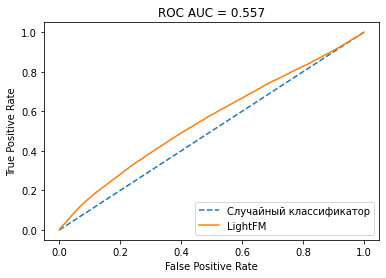

In [82]:
roc_auc_curve(test_data.rating,preds1)

#### We can see that the model with the best hyperparameters works worse than deafult model, so let's proceed with looking for the set hyperparameters in an empirical way (by trials and errors)

### Let's build a default model with item_features

In [83]:
#Adding item features. For now we`re adding just **vote**
total_items = max(train_data['itemid'].max(), test_data['itemid'].max()) + 1
identity_matrix = sparse.identity(total_items)
item_features = sparse.coo_matrix(identity_matrix, train_data[['vote']])

In [84]:
# Default model with user_features
model2 = LightFM()
model2 = model2.fit(ratings_coo)

In [85]:
#Preds for ROC AUC
preds2 = model2.predict(test_data.userid.values,
                      test_data.itemid.values)

In [86]:
sklearn.metrics.roc_auc_score(test_data.rating,preds2)

0.6103342103253341

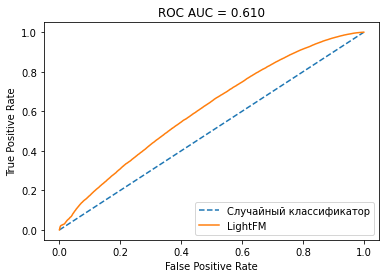

In [87]:
roc_auc_curve(test_data.rating,preds2)

#### As we can see the model with user_features but without hyperparameters also works not well. Let's try to find good hyperparameters

#### Building a model with hyperparameters tuned empirically and only **vote** as item_features

In [88]:
# Here in this model we use hyperparameters that were chosen by the trial and error method
NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 160 #число параметров вектора 
NUM_EPOCHS = 20 #число эпох обучения

model3 = LightFM(learning_rate=0.09, loss='logistic',
                no_components=NUM_COMPONENTS)
model3 = model3.fit(ratings_coo, epochs=NUM_EPOCHS,item_features=item_features,num_threads=NUM_THREADS)

In [89]:
#Preds for ROC AUC
preds3 = model3.predict(test_data.userid.values,
                      test_data.itemid.values,
                     item_features=item_features)

In [90]:
sklearn.metrics.roc_auc_score(test_data.rating,preds3)

0.7311713934096272

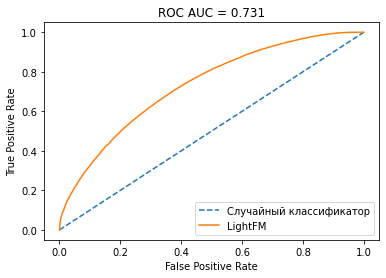

In [91]:
roc_auc_curve(test_data.rating,preds3)

#### As we can see the model with empirically tuned hyperparameters and the **vote** feature as a item_feature, works much better than default model

#### Let's now building a model with hyperparameters tuned empirically and all available item_features

In [92]:
train.head()

,verified,unixReviewTime,vote,image,userid,itemid,rating,summary_tone
0,1,2,0,0,102179,37138,1.0,0
1,1,2,0,0,3625,17322,1.0,0
2,1,2,28,0,39495,5600,1.0,1
3,1,1,0,0,72854,30249,1.0,0
4,1,2,0,0,74859,4349,1.0,1


In [93]:
item_features = sparse.coo_matrix(identity_matrix, train_data[['vote', 'verified', 'unixReviewTime', 'image', 'summary_tone']])

In [94]:
# Here in this model we use hyperparameters that are chosen by the trial and error method
NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 160 #число параметров вектора 
NUM_EPOCHS = 20 #число эпох обучения

model4 = LightFM(learning_rate=0.09, loss='logistic',
                no_components=NUM_COMPONENTS)
model4 = model4.fit(ratings_coo, epochs=NUM_EPOCHS,item_features=item_features,num_threads=NUM_THREADS)

In [95]:
#Preds for ROC AUC
preds4 = model4.predict(test_data.userid.values,
                      test_data.itemid.values,
                     item_features=item_features)

In [96]:
sklearn.metrics.roc_auc_score(test_data.rating,preds4)

0.7315062225228067

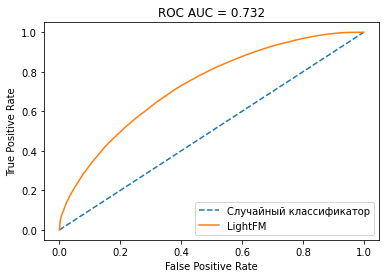

In [97]:
roc_auc_curve(test_data.rating,preds4)

#### As we can see the model with all available item_features works not better than the model with only **vote** as item feature

#### Let's try to build a model with the most important item features only

In [98]:
item_features = sparse.coo_matrix(identity_matrix, train_data[['vote', 'verified', 'summary_tone']])

In [99]:
# Here in this model we use hyperparameters that are chosen by the trial and error method
NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 160 #число параметров вектора 
NUM_EPOCHS = 20 #число эпох обучения

model5 = LightFM(learning_rate=0.09, loss='logistic',
                no_components=NUM_COMPONENTS)
model5 = model5.fit(ratings_coo, epochs=NUM_EPOCHS,item_features=item_features,num_threads=NUM_THREADS)

In [100]:
#Preds for ROC AUC
preds5 = model5.predict(test_data.userid.values,
                      test_data.itemid.values,
                     item_features=item_features)

In [101]:
sklearn.metrics.roc_auc_score(test_data.rating,preds5)

0.731636793588947

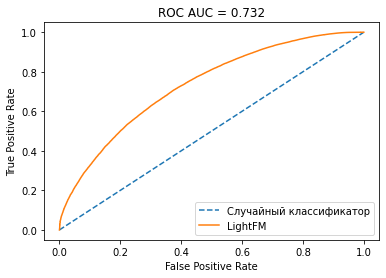

In [102]:
roc_auc_curve(test_data.rating,preds5)

#### The model with the best item_features as an additional features works slightly better, than with **vote** item_feature only. However, Kaggle Leaderboard didn't show any improvements on the results

#### What else we can do to improve our best model, which is **model3** with the **vote** only feature as an item_feature. Let's try to Standartize the **vote** feature

In [103]:
train['vote'] = StandardScaler().fit_transform(train[['vote']])

In [104]:
item_features = sparse.coo_matrix(identity_matrix, train_data[['vote']])

In [105]:
# Here in this model we use hyperparameters that were chosen by the trial and error method
NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 160 #число параметров вектора 
NUM_EPOCHS = 20 #число эпох обучения

model6 = LightFM(learning_rate=0.09, loss='logistic',
                no_components=NUM_COMPONENTS)
model6 = model6.fit(ratings_coo, epochs=NUM_EPOCHS,item_features=item_features,num_threads=NUM_THREADS)

In [106]:
#Preds for ROC AUC
preds6 = model6.predict(test_data.userid.values,
                      test_data.itemid.values,
                     item_features=item_features)

In [107]:
sklearn.metrics.roc_auc_score(test_data.rating,preds6)

0.7311776783896264

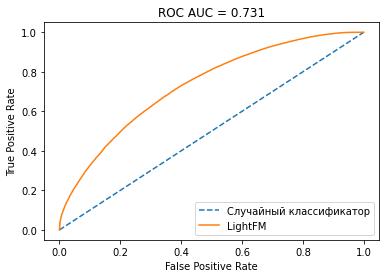

In [108]:
roc_auc_curve(test_data.rating,preds6)

#### As we can see after standartization of the feature **vote**, the model still doesn't perform better than model3. So, for now we will go with model3 as our final Submission to Kaggle.

## Submission

In [109]:
#Preds Final
preds_final = model3.predict(test.userid.values,
                      test.itemid.values,
                     item_features=item_features)

In [110]:
preds_final.min(), preds_final.max()

(-35.172271728515625, 35.308780670166016)

In [111]:
normalized_preds = (preds_final - preds_final.min())/(preds_final - preds_final.min()).max()

In [112]:
normalized_preds.min(), normalized_preds.max()

(0.0, 1.0)

In [113]:
submission.shape

(285965, 2)

In [114]:
normalized_preds.shape

(285965,)

In [115]:
submission['rating']= normalized_preds

In [116]:
submission.to_csv('submission_log.csv', index=False)

## What else can be done to improve our model? 

There is a document with meta data about  items. We can use this data as item_features and try to improve the model's results. However, as long as the item features that existed in the original train dataset didn't proved themselves as good parameters to improve the model's result, I won't spend time on this right now and will go ahead with the course.